## Import the Model

In [1]:
import tensorflow as tf
from tensorflow.python.keras.applications.vgg19 import VGG19

In [2]:
model = VGG19(
    include_top = False,
    weights = "imagenet"
)
model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Import Libraries and Helper Functions

In [3]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

## Image Processing and Display

In [4]:
def load_and_process_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis = 0)
    return img

In [5]:
def deprocess(x):
    x[:, :, 0] +=  103.939
    x[:, :, 1] +=  116.779
    x[:, :, 2] +=  123.68
    x = x[:, :, ::-1]
    
    x = np.clip(x, 0, 255)
    x = x.astype("uint8")
    
    return x

def display_image(image):
    if len(image.shape) == 4:
        image = np.squeeze(image, axis = 0)
        
    image = deprocess(image)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    
    return 

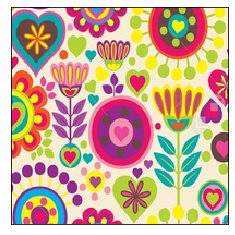

In [6]:
style = load_and_process_image("color.jpg")
display_image(style)

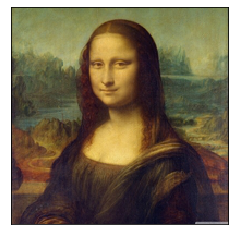

In [7]:
content = load_and_process_image("mona.jpg")
display_image(content)

## Content and Style Models

In [8]:
content_layer = "block5_conv2"

style_layers = [
    "block1_conv1",
    "block3_conv1",
    "block5_conv1"
]

content_model = Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output
)

style_models = [
    Model(
        inputs = model.input,
        outputs = model.get_layer(content_layer).output
    ) for layer in style_layers
]

## Content Cost

In [9]:
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    
    return cost

## Gram Matrix

In [10]:
def gram_matrix(A):
    n_C = int(A.shape[-1])
    a = tf.reshape(A, [-1, n_C])
    n = tf.shape(a)[0]
    G = tf.matmul(a, a, transpose_a = True)
    G = G/tf.cast(n, tf.float32)
    return G

## Style Cost

In [11]:
lam = 1./len(style_models)

def style_cost(style, generated):
    J_style = 0.
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        
        J_style += current_cost * lam
        
    return J_style

## Training Loop

In [12]:
import time

generated_images = []

def training_loop(content_path, style_path, iterations = 20, a = 10., b = 20.):
    # initialise
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype = tf.float32)
    
    opt = tf.optimizers.Adam(learning_rate = 7.)
    
    best_cost = 1e12 + 0.1
    best_image = None
    
    start_time = time.time()
    
    for i in range(iterations):
        
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style
        
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
        
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
        
        if i % int(iterations/10) == 0:
            time_taken = time.time() - start_time
            print('Cost at {}: {}. Time elapsed: {}'.format(i, J_total, time_taken))
            generated_images.append(generated.numpy())
        
    return best_image

In [13]:
final = training_loop('mona.jpg', 'color.jpg')

Cost at 0: 161512080.0. Time elapsed: 6.263295650482178
Cost at 2: 85686296.0. Time elapsed: 17.629475355148315
Cost at 4: 54456860.0. Time elapsed: 28.459164142608643
Cost at 6: 36373816.0. Time elapsed: 39.27010941505432
Cost at 8: 27092086.0. Time elapsed: 50.260658979415894
Cost at 10: 22165070.0. Time elapsed: 61.301186084747314
Cost at 12: 18273606.0. Time elapsed: 72.76964926719666
Cost at 14: 15313091.0. Time elapsed: 84.86738085746765
Cost at 16: 13184392.0. Time elapsed: 96.81675601005554
Cost at 18: 11916692.0. Time elapsed: 108.81692481040955


## Plot the Results

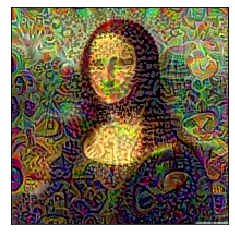

In [14]:
display_image(final)

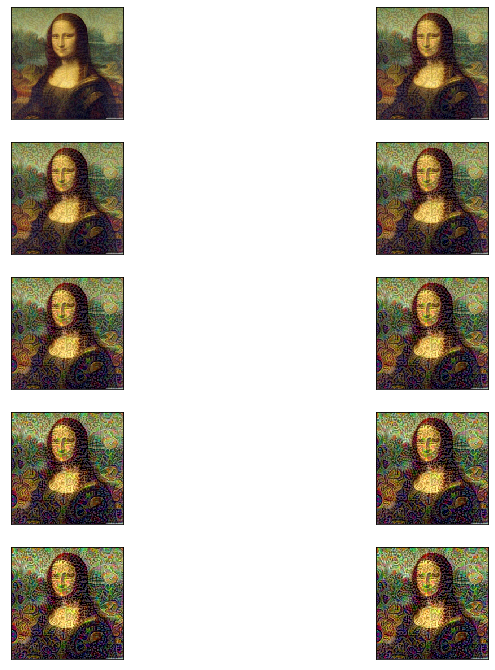

In [15]:
plt.figure(figsize = (12, 12))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    display_image(generated_images[i])
plt.show()